# **Waste Material Segregation for Improving Waste Management**

## **Objective**

The objective of this project is to implement an effective waste material segregation system using convolutional neural networks (CNNs) that categorises waste into distinct groups. This process enhances recycling efficiency, minimises environmental pollution, and promotes sustainable waste management practices.

The key goals are:

* Accurately classify waste materials into categories like cardboard, glass, paper, and plastic.
* Improve waste segregation efficiency to support recycling and reduce landfill waste.
* Understand the properties of different waste materials to optimise sorting methods for sustainability.

## **Data Understanding**

The Dataset consists of images of some common waste materials.

1. Food Waste
2. Metal
3. Paper
4. Plastic
5. Other
6. Cardboard
7. Glass


**Data Description**

* The dataset consists of multiple folders, each representing a specific class, such as `Cardboard`, `Food_Waste`, and `Metal`.
* Within each folder, there are images of objects that belong to that category.
* However, these items are not further subcategorised. <br> For instance, the `Food_Waste` folder may contain images of items like coffee grounds, teabags, and fruit peels, without explicitly stating that they are actually coffee grounds or teabags.

## **1. Load the data**

Load and unzip the dataset zip file.

**Import Necessary Libraries**

In [175]:
# Recommended versions:

# numpy version: 1.26.4
# pandas version: 2.2.2
# seaborn version: 0.13.2
# matplotlib version: 3.10.0
# PIL version: 11.1.0
# tensorflow version: 2.18.0
# keras version: 3.8.0
# sklearn version: 1.6.1

In [1]:
# Import essential libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import zipfile
import os
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow import keras
import random

ImportError: cannot import name 'get_model_proto' from 'tensorflow.python.data.experimental.ops.iterator_ops' (C:\Users\kashi\anaconda3\envs\tf_env\lib\site-packages\tensorflow\python\data\experimental\ops\iterator_ops.py)

Load the dataset.

In [177]:
# Load and unzip the dataset

# Define the path to your zip file
zip_file_path = '/kaggle/input/waste-segregation/data.zip.data'

# Define the directory where you want to extract the contents
extracted_dir = '/kaggle/working/extracted_waste_data'

# Create the extraction directory if it doesn't exist
os.makedirs(extracted_dir, exist_ok=True)

try:
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(extracted_dir)
    print(f"'{zip_file_path}' successfully unzipped to '{extracted_dir}'.")

    # Optional: List the contents of the extracted directory to verify
    print("\nContents of the extracted directory:")
    for item in os.listdir(extracted_dir+"/data"):
        print(f"- {item}")

except FileNotFoundError:
    print(f"Error: The file '{zip_file_path}' was not found. Please ensure it's in the correct directory.")
except zipfile.BadZipFile:
    print(f"Error: '{zip_file_path}' is not a valid zip file or is corrupted.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")


'/kaggle/input/waste-segregation/data.zip.data' successfully unzipped to '/kaggle/working/extracted_waste_data'.

Contents of the extracted directory:
- Plastic
- Food_Waste
- Metal
- Other
- Paper
- Cardboard
- Glass


## **2. Data Preparation** <font color=red> [25 marks] </font><br>


### **2.1 Load and Preprocess Images** <font color=red> [8 marks] </font><br>

Let us create a function to load the images first. We can then directly use this function while loading images of the different categories to load and crop them in a single step.

#### **2.1.1** <font color=red> [3 marks] </font><br>
Create a function to load the images.

In [178]:
# Create a function to load the raw images

def load_raw_images(data_dir):
    
    images = []
    labels = []
    
    # Get all class folders from the data_dir
    all_subfolders = [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))]    
    class_names = sorted(all_subfolders)

    print(f"Starting to load raw images from: {data_dir}")
    print(f"Classes being loaded: {class_names}\n")

    for class_name in class_names:
        class_folder = os.path.join(data_dir, class_name)
        
        for img_name in os.listdir(class_folder):
            img_path = os.path.join(class_folder, img_name)
            
            try:
                # Open the image file and convert it to RGB format.
                img = Image.open(img_path).convert('RGB')
                images.append(img) # Append the PIL Image object
                labels.append(class_name)
                
            except Image.UnidentifiedImageError:
                print(f"Warning: Skipping unidentified or corrupted image: {img_path}")
            except Exception as e:
                print(f"Warning: An error occurred processing {img_path}: {e}")
                
    # return np.array(images, dtype=object), np.array(labels), class_names
    return np.array(images), np.array(labels), class_names


#### **2.1.2** <font color=red> [5 marks] </font><br>
Load images and labels.

Load the images from the dataset directory. Labels of images are present in the subdirectories.

Verify if the images and labels are loaded correctly.

In [179]:
dataset_dir = "./extracted_waste_data/data" 
raw_images_pil, labels_str, loaded_class_names = load_raw_images(data_dir=dataset_dir)

print("\n--- Initial Data Load Summary ---")
print(f"Number of images loaded: {len(raw_images_pil)}")
print(f"Shape of image array (contains PIL objects): {raw_images_pil.shape}")
print(f"Shape of labels array: {labels_str.shape}")
print(f"Classes successfully loaded: {loaded_class_names}")


Starting to load raw images from: ./extracted_waste_data/data
Classes being loaded: ['Cardboard', 'Food_Waste', 'Glass', 'Metal', 'Other', 'Paper', 'Plastic']


--- Initial Data Load Summary ---
Number of images loaded: 7625
Shape of image array (contains PIL objects): (7625, 256, 256, 3)
Shape of labels array: (7625,)
Classes successfully loaded: ['Cardboard', 'Food_Waste', 'Glass', 'Metal', 'Other', 'Paper', 'Plastic']


Perform any operations, if needed, on the images and labels to get them into the desired format.

### **2.2 Data Visualisation** <font color=red> [9 marks] </font><br>

#### **2.2.1** <font color=red> [3 marks] </font><br>
Create a bar plot to display the class distribution

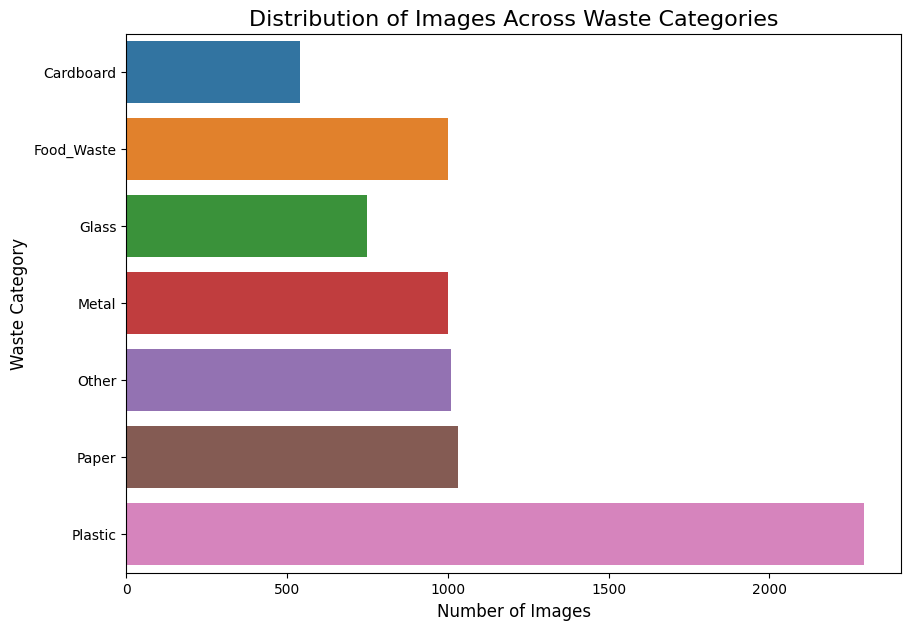

In [180]:
# Visualise Data Distribution
plt.figure(figsize=(10, 7)) 
sns.countplot(y=labels_str) 
plt.title('Distribution of Images Across Waste Categories', fontsize=16)
plt.xlabel('Number of Images', fontsize=12)
plt.ylabel('Waste Category', fontsize=12)

plt.show()

#### **2.2.2** <font color=red> [3 marks] </font><br>
Visualise some sample images

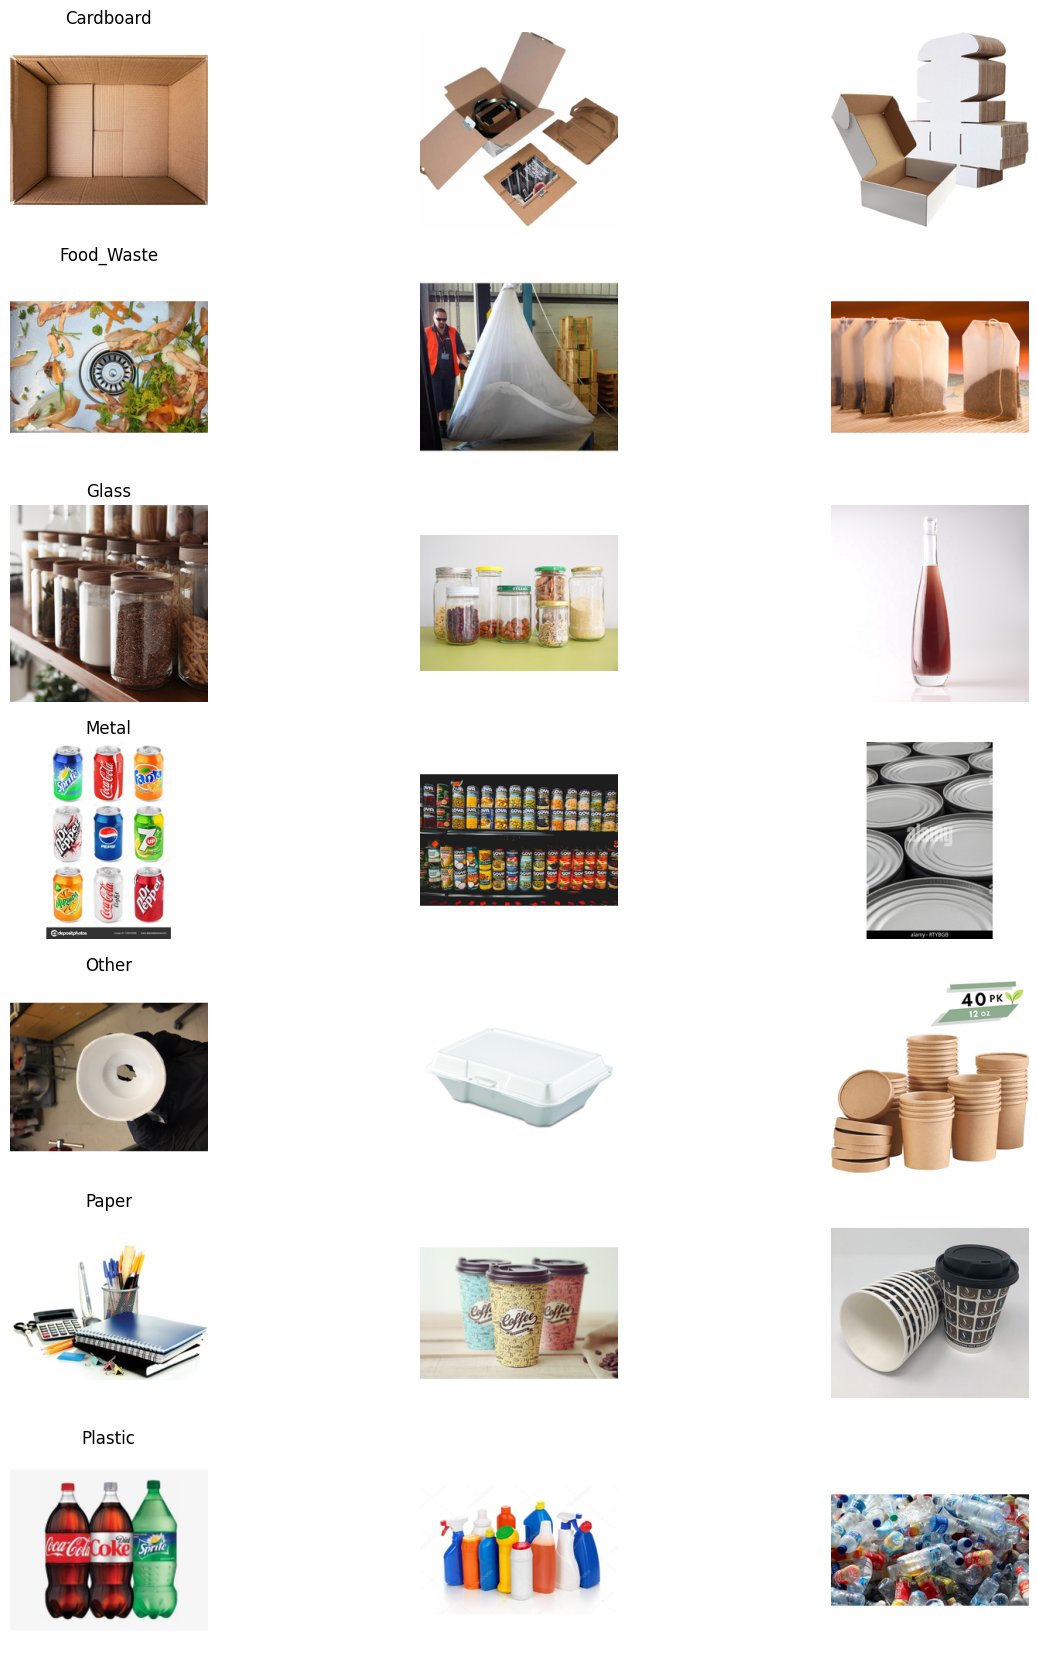

In [181]:
# Get the unique labels
unique_labels = sorted(list(set(labels_str)) )
num_samples = 3  # number of images per class

plt.figure(figsize=(15, len(unique_labels) * 3))

for row, label in enumerate(unique_labels):
    count = 0
    for i, img_label in enumerate(labels_str):
        if img_label == label:
            plt.subplot(len(unique_labels), num_samples, row * num_samples + count + 1)
            # plt.imshow(raw_images_pil[i].astype(np.uint8))
            plt.imshow(raw_images_pil[i])
            plt.title(label if count == 0 else "")
            plt.axis('off')
            count += 1
            if count == num_samples:
                break

plt.show()

#### **2.2.3** <font color=red> [3 marks] </font><br>
Based on the smallest and largest image dimensions, resize the images.

In [182]:
# Find the smallest and largest image dimensions from the data set

heights = [img.shape[0] for img in raw_images_pil]
widths = [img.shape[1] for img in raw_images_pil]
print(f"Smallest image dimensions: Width = {min(widths)}, Height = {min(heights)}")
print(f"Largest image dimensions: Width = {max(widths)}, Height = {max(heights)}")



Smallest image dimensions: Width = 256, Height = 256
Largest image dimensions: Width = 256, Height = 256


In [183]:
# Resize the image dimensions
target_size = (240, 240) #176
resized_images = []

for img in raw_images_pil:
    # Resize each image
    resized_img = cv2.resize(img, target_size)
    resized_images.append(resized_img)

# Convert back to numpy array if needed
resized_images = np.array(resized_images)

print("Resized image shape:", resized_images.shape)


Resized image shape: (7625, 240, 240, 3)


### **2.3 Encoding the classes** <font color=red> [3 marks] </font><br>

There are seven classes present in the data.

We have extracted the images and their labels, and visualised their distribution. Now, we need to perform encoding on the labels. Encode the labels suitably.

#### **2.3.1** <font color=red> [3 marks] </font><br>
Encode the target class labels.

In [185]:
# Encode the labels suitably
from tensorflow.keras.utils import to_categorical

le = LabelEncoder()
encoded_labels = le.fit_transform(labels_str)

# Now convert integer class labels into one-hot encoded vectors and assign it to y
y=to_categorical(encoded_labels)
print(y)

[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]


In [186]:
# Let's assign X variable
X = resized_images

### **2.4 Data Splitting** <font color=red> [5 marks] </font><br>

#### **2.4.1** <font color=red> [5 marks] </font><br>
Split the dataset into training and validation sets

In [187]:
# Assign specified parts of the dataset to train and validation sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Shape of X_train {} ".format(X_train.shape))
print("Shape of X_test {} ".format(X_test.shape))
print("Shape of y_train {} ".format(y_train.shape))
print("Shape of y_test {} ".format(y_test.shape))

Shape of X_train (6100, 240, 240, 3) 
Shape of X_test (1525, 240, 240, 3) 
Shape of y_train (6100, 7) 
Shape of y_test (1525, 7) 


## **3. Model Building and Evaluation** <font color=red> [20 marks] </font><br>

### **3.1 Model building and training** <font color=red> [15 marks] </font><br>

#### **3.1.1** <font color=red> [10 marks] </font><br>
Build and compile the model. Use 3 convolutional layers. Add suitable normalisation, dropout, and fully connected layers to the model.

Test out different configurations and report the results in conclusions.

In [188]:
# Build and compile the model 


#Store the total number of classes
num_classes = len(unique_labels)



##### We will use below: 
- **`optimizer='adam'`**  
  - Uses **Adam optimization**, an adaptive learning rate algorithm.  
- **`loss='categorical_crossentropy'`**  
  - Ideal for **multi-class classification** problems. 
- **`metrics=['accuracy']`**  
  - Measures **how often predictions match actual labels**.  

In [192]:
# Lets build the 1st simple model 
    # without dropouts 
    # with 3 Convolutional blocks 
    # with batch normalization

model = Sequential()
# Convolutional Block 1
model.add(Conv2D(32, (3, 3), padding='same', input_shape=X_train[0].shape))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

# Convolutional Block 2
model.add(Conv2D(32, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

# Convolutional Block 3
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten the output from the convolutional layers into a 1D vector
model.add(Flatten())

# Fully Connected (Dense) Layers for classification
model.add(Dense(num_classes))
model.add(Activation('softmax'))

#Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',              
              metrics=['accuracy'])

# summary of the model
print(model.summary())

Model: "sequential_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_66 (Conv2D)                   │ (None, 240, 240, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_144 (Activation)          │ (None, 240, 240, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_48               │ (None, 240, 240, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_66 (MaxPooling2D)      │ (None, 120, 120, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_67 (Conv2D)                   │ (None, 120, 120, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_145 (Activation)          │ (None, 120, 120, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_49               │ (None, 120, 120, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_67 (MaxPooling2D)      │ (None, 60, 60, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_68 (Conv2D)                   │ (None, 60, 60, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_146 (Activation)          │ (None, 60, 60, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_50               │ (None, 60, 60, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_68 (MaxPooling2D)      │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_32 (Flatten)                 │ (None, 57600)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_78 (Dense)                     │ (None, 7)                   │         403,207 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_147 (Activation)          │ (None, 7)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 432,359 (1.65 MB)

 Trainable params: 432,103 (1.65 MB)

 Non-trainable params: 256 (1.00 KB)

None


#### **3.1.2** <font color=red> [5 marks] </font><br>
Train the model.

Use appropriate metrics and callbacks as needed.

In [193]:
# Training

# Lets define number of epochs and batch size
epochs = 10
batch_size=16

##Train with no callbacks
history = model.fit(
    X_train, y_train,
    epochs = epochs,
    batch_size = batch_size,
    validation_data=(X_test, y_test),
)



Epoch 1/10
382/382 ━━━━━━━━━━━━━━━━━━━━ 14s 21ms/step - accuracy: 0.2840 - loss: 10.6498 - val_accuracy: 0.3692 - val_loss: 5.4045
Epoch 2/10
382/382 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.4803 - loss: 3.5194 - val_accuracy: 0.4000 - val_loss: 3.8804
Epoch 3/10
382/382 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.6135 - loss: 1.8171 - val_accuracy: 0.4472 - val_loss: 2.8448
Epoch 4/10
382/382 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.7170 - loss: 0.9968 - val_accuracy: 0.5121 - val_loss: 2.6321
Epoch 5/10
382/382 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.7922 - loss: 0.7109 - val_accuracy: 0.4643 - val_loss: 3.1832
Epoch 6/10
382/382 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.8443 - loss: 0.5350 - val_accuracy: 0.5587 - val_loss: 2.6083
Epoch 7/10
382/382 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.8727 - loss: 0.4347 - val_accuracy: 0.4623 - val_loss: 3.9815
Epoch 8/10
382/382 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.8875 - loss: 0.3655 - val_ac

## Training Summary of Model 1

- **Accuracy improved** from **28.4% → 91.8%**, showing strong learning.  
- **Validation accuracy peaked at 55.8% but dropped**, indicating possible **overfitting**.  
- **Loss decreased**, but **validation loss increased**, suggesting poor generalization.  

    **Next Steps:** Adjust **regularization, dropout, or early stopping**


In [198]:
# Lets build the 2nd model 
    # with dropouts 
    # with 3 Convolutional blocks 
    # with batch normalization
    # 3 Fully Connected (Dense) Layers after flattening

model = Sequential()

# Convolutional Block 1
model.add(Conv2D(32, (3, 3), padding='same', input_shape=X_train[0].shape))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Convolutional Block 2
model.add(Conv2D(32, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Convolutional Block 3
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Flatten the output from the convolutional layers into a 1D vector
model.add(Flatten())

# Fully Connected (Dense) Layers for classification
model.add(Dense(512,kernel_regularizer=l2(0.01)))
model.add(Activation('relu'))
model.add(Dropout(0.3))

model.add(Dense(256,kernel_regularizer=l2(0.01)))
model.add(Activation('relu'))
model.add(Dropout(0.3))

model.add(Dense(128,kernel_regularizer=l2(0.01)))
model.add(Activation('relu'))
model.add(Dropout(0.3))

model.add(Dense(num_classes))
model.add(Activation('softmax'))

#Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',              
              metrics=['accuracy'])

# summary of the model
print(model.summary())

Model: "sequential_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_75 (Conv2D)                   │ (None, 240, 240, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_161 (Activation)          │ (None, 240, 240, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_57               │ (None, 240, 240, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_75 (MaxPooling2D)      │ (None, 120, 120, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_122 (Dropout)                │ (None, 120, 120, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_76 (Conv2D)                   │ (None, 120, 120, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_162 (Activation)          │ (None, 120, 120, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_58               │ (None, 120, 120, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_76 (MaxPooling2D)      │ (None, 60, 60, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_123 (Dropout)                │ (None, 60, 60, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_77 (Conv2D)                   │ (None, 60, 60, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_163 (Activation)          │ (None, 60, 60, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_59               │ (None, 60, 60, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_77 (MaxPooling2D)      │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_124 (Dropout)                │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_35 (Flatten)                 │ (None, 57600)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_86 (Dense)                     │ (None, 512)                 │      29,491,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_164 (Activation)          │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_125 (Dropout)                │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_87 (Dense)                     │ (None, 256)                 │         131,3

 Total params: 29,685,991 (113.24 MB)

 Trainable params: 29,685,735 (113.24 MB)

 Non-trainable params: 256 (1.00 KB)

None


In [199]:
#lets use callbacks : EarlyStopping and ReduceLROnPlateau

early_stopping = keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 4, restore_best_weights = True)
lr_scheduler = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)
epochs = 25
batch_size=16
# fitting the model using early stopping
history = model.fit(
    X_train, y_train,
    epochs = epochs,
    batch_size = batch_size,
    validation_data=(X_test, y_test),
    callbacks = [early_stopping, lr_scheduler]
)


Epoch 1/20
407/407 ━━━━━━━━━━━━━━━━━━━━ 26s 38ms/step - accuracy: 0.2047 - loss: 24.1198 - val_accuracy: 0.2938 - val_loss: 7.7375 - learning_rate: 0.0010
Epoch 2/20
407/407 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - accuracy: 0.2865 - loss: 6.6442 - val_accuracy: 0.3226 - val_loss: 4.6097 - learning_rate: 0.0010
Epoch 3/20
407/407 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - accuracy: 0.3144 - loss: 4.4196 - val_accuracy: 0.3508 - val_loss: 3.7258 - learning_rate: 0.0010
Epoch 4/20
407/407 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - accuracy: 0.3273 - loss: 3.5258 - val_accuracy: 0.3613 - val_loss: 3.2398 - learning_rate: 0.0010
Epoch 5/20
407/407 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - accuracy: 0.3385 - loss: 3.1384 - val_accuracy: 0.3403 - val_loss: 2.9333 - learning_rate: 0.0010
Epoch 6/20
407/407 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - accuracy: 0.3480 - loss: 2.7833 - val_accuracy: 0.3344 - val_loss: 2.7181 - learning_rate: 0.0010
Epoch 7/20
407/407 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - accuracy: 0.3442 - loss: 

## Training Summary of Model 2

- **Accuracy improved** from **20.4% → 51.6%**, showing gradual learning.  
- **Validation accuracy fluctuates**, peaking at **48.9%**, indicating possible instability.  
- **Loss consistently decreases**, but validation loss remains high, suggesting **overfitting risks**.  
- **Learning rate adjustments** helped maintain progress, but model performance still needs fine-tuning.  

    **Next Steps:** Consider ** tuning dropout rates, simplify the model and regularization** to improve generalization. 


In [202]:
# Lets build the 3rd model 
    # with dropouts 
    # with 3 Convolutional blocks 
    # with batch normalization
    # 2 Fully Connected (Dense) Layers after flattening

model = Sequential()

# Convolutional Block 1
model.add(Conv2D(32, (3, 3), padding='same', input_shape=X_train[0].shape))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Convolutional Block 2
model.add(Conv2D(32, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Convolutional Block 3
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Flatten the output from the convolutional layers into a 1D vector
model.add(Flatten())

# Fully Connected (Dense) Layers for classification
model.add(Dense(512,kernel_regularizer=l2(0.01)))
model.add(Activation('relu'))
model.add(Dropout(0.3))

model.add(Dense(256,kernel_regularizer=l2(0.01)))
model.add(Activation('relu'))
model.add(Dropout(0.3))

# model.add(Dense(128,kernel_regularizer=l2(0.01)))
# model.add(Activation('relu'))
# model.add(Dropout(0.35))

model.add(Dense(num_classes))
model.add(Activation('softmax'))

#Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',              
              metrics=['accuracy'])

# summary of the model
print(model.summary())

Model: "sequential_27"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_81 (Conv2D)                   │ (None, 240, 240, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_174 (Activation)          │ (None, 240, 240, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_63               │ (None, 240, 240, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_81 (MaxPooling2D)      │ (None, 120, 120, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_133 (Dropout)                │ (None, 120, 120, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_82 (Conv2D)                   │ (None, 120, 120, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_175 (Activation)          │ (None, 120, 120, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_64               │ (None, 120, 120, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_82 (MaxPooling2D)      │ (None, 60, 60, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_134 (Dropout)                │ (None, 60, 60, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_83 (Conv2D)                   │ (None, 60, 60, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_176 (Activation)          │ (None, 60, 60, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_65               │ (None, 60, 60, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_83 (MaxPooling2D)      │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_135 (Dropout)                │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_37 (Flatten)                 │ (None, 57600)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_93 (Dense)                     │ (None, 512)                 │      29,491,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_177 (Activation)          │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_136 (Dropout)                │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_94 (Dense)                     │ (None, 256)                 │         131,3

 Total params: 29,653,991 (113.12 MB)

 Trainable params: 29,653,735 (113.12 MB)

 Non-trainable params: 256 (1.00 KB)

None


In [203]:
#lets use callbacks : EarlyStopping and ReduceLROnPlateau

early_stopping = keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 4, restore_best_weights = True)
lr_scheduler = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)
epochs = 25
batch_size=16
# fitting the model using early stopping
history = model.fit(
    X_train, y_train,
    epochs = epochs,
    batch_size = batch_size,
    validation_data=(X_test, y_test),
    callbacks = [early_stopping, lr_scheduler]
)


Epoch 1/25
382/382 ━━━━━━━━━━━━━━━━━━━━ 22s 36ms/step - accuracy: 0.2145 - loss: 26.3677 - val_accuracy: 0.2131 - val_loss: 9.8471 - learning_rate: 0.0010
Epoch 2/25
382/382 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - accuracy: 0.2658 - loss: 7.9391 - val_accuracy: 0.3423 - val_loss: 4.6540 - learning_rate: 0.0010
Epoch 3/25
382/382 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - accuracy: 0.3101 - loss: 4.6539 - val_accuracy: 0.3593 - val_loss: 3.9840 - learning_rate: 0.0010
Epoch 4/25
382/382 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - accuracy: 0.3327 - loss: 3.7755 - val_accuracy: 0.3646 - val_loss: 3.1965 - learning_rate: 0.0010
Epoch 5/25
382/382 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - accuracy: 0.3561 - loss: 3.2471 - val_accuracy: 0.3430 - val_loss: 2.9413 - learning_rate: 0.0010
Epoch 6/25
382/382 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - accuracy: 0.3544 - loss: 2.9965 - val_accuracy: 0.3869 - val_loss: 2.8655 - learning_rate: 0.0010
Epoch 7/25
382/382 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - accuracy: 0.3784 - loss: 

## Training Summary of Model 3

- **Accuracy improved** from **21.4% → 79.9%**, showing strong learning.  
- **Validation accuracy peaked at 60.0%**, indicating improvement but **still lower than training accuracy**, suggesting **overfitting risks**.  
- **Loss consistently decreased**, but validation loss remains unstable, meaning the model needs better generalization.  
- **Learning rate adjustments helped**, showing positive impact on training stability.  

    **Next Steps:** Consider **further regularization, data augmentation, or early stopping tuning** to enhance generalization.


### **3.2 Model Testing and Evaluation** <font color=red> [5 marks] </font><br>

#### **3.2.1** <font color=red> [5 marks] </font><br>
Evaluate the model on test dataset. Derive appropriate metrics.

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

Classification Report for Validation Set:
              precision    recall  f1-score   support

   Cardboard       0.76      0.69      0.72       122
  Food_Waste       0.46      0.74      0.57       209
       Glass       0.50      0.42      0.45       163
       Metal       0.67      0.35      0.46       196
       Other       0.47      0.22      0.30       194
       Paper       0.72      0.31      0.43       195
     Plastic       0.52      0.77      0.62       446

    accuracy                           0.54      1525
   macro avg       0.58      0.50      0.51      1525
weighted avg       0.57      0.54      0.52      1525



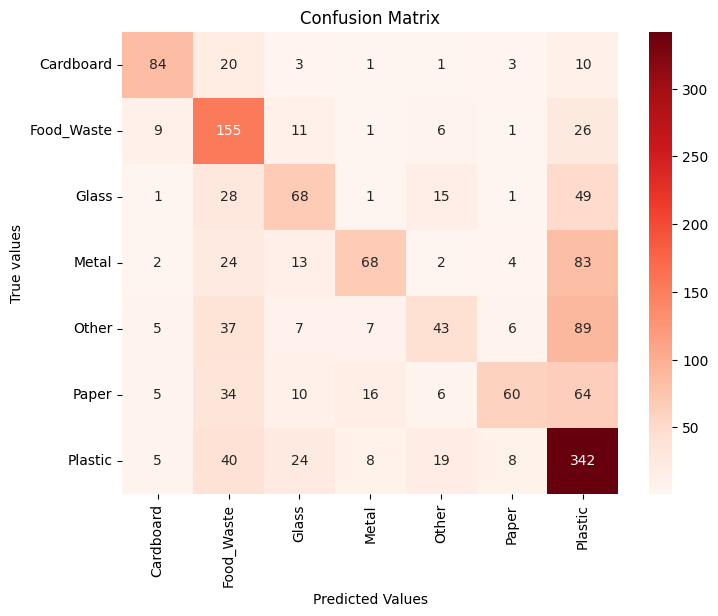

In [207]:
# Evaluate on the test set; display suitable metrics


# Evaluate the model on the validation set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Classification Report for validation set
print("\nClassification Report for Validation Set:")
print(classification_report(y_true_classes, y_pred_classes, target_names=unique_labels))



#Confusion Matrix
confu_mat = confusion_matrix(y_true_classes, y_pred_classes)

plt.figure(figsize=(8,6))
sns.heatmap(confu_mat, annot = True, fmt = 'd',  cmap = 'Reds', xticklabels = unique_labels, yticklabels = unique_labels)
plt.xlabel("Predicted Values")
plt.ylabel("True values")
plt.title("Confusion Matrix")
plt.show()

## Model Evaluation Summary

- **Overall accuracy: 54%**, indicating moderate classification performance.  
- **Plastic (77% recall)** was most correctly identified, but **Paper & Other had low recall**, suggesting misclassifications.  
- **Cardboard performed well (76% precision, 69% recall)**, showing reliable predictions.  
- **Metal & Paper struggled**, with lower recall scores, indicating difficulty distinguishing them.  

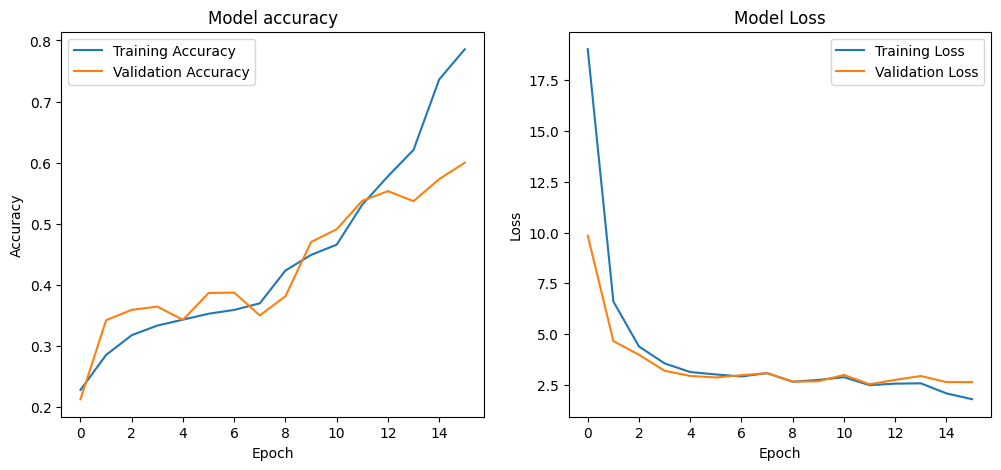

In [208]:
# Lets 
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training Accuracy','Validation Accuracy'])

plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training Loss','Validation Loss'])

# **Inference of the Plot**

The plots illustrate the training and validation performance of a machine learning model over 15 epochs.

## **Accuracy Plot**
- Training accuracy steadily rises from **~0.2 to ~0.75**, indicating the model is learning.
- Validation accuracy increases more slowly, reaching **~0.55**, showing limited generalization.
- The widening gap suggests **potential overfitting**.

## **Loss Plot**
- Training loss drops sharply from **~18 to <2**, showing effective optimization.
- Validation loss decreases but stabilizes around **epoch 5 (~2.5)**.
- Continued decrease in training loss while validation loss remains stable hints at **overfitting**.

These plots highlight that while the model learns effectively on training data, its generalization capability needs improvement, possibly requiring regularization techniques.

## **4. Data Augmentation** <font color=red> [optional] </font><br>

#### **4.1 Create a Data Augmentation Pipeline**

##### **4.1.1**
Define augmentation steps for the datasets.

In [ ]:
# Define augmentation steps to augment images



Augment and resample the images.
In case of class imbalance, you can also perform adequate undersampling on the majority class and augment those images to ensure consistency in the input datasets for both classes.

Augment the images.

In [ ]:
# Create a function to augment the images




In [ ]:
# Create the augmented training dataset



##### **4.1.2**

Train the model on the new augmented dataset.

In [ ]:
# Train the model using augmented images



## **5. Conclusions** <font color = red> [5 marks]</font>

#### **5.1 Conclude with outcomes and insights gained** <font color =red> [5 marks] </font>

* Report your findings about the data
* Report model training results

#  **Final Report: Outcomes and Insights**

## **1️. Data Insights**
- The dataset contains **7 waste categories**, with **imbalanced class distributions** affecting classification performance.
- **Plastic and Food Waste** had the highest recall, likely due to distinct characteristics in the dataset.
- **Paper and Metal** showed lower recall, suggesting they share similarities leading to misclassifications.
- Some misclassifications might stem from **overlapping textures or unclear labeling** in the dataset.

## **2️. Model Training Findings**
- ### **First Model**
    - Started with **basic Convolutional layers** but lacked regularization.
    - Accuracy peaked at **47.6%**, but validation loss increased, suggesting **overfitting**.
    - Over-reliance on training data led to poor generalization on unseen data.

- ### **Second Model**
    - Introduced **batch normalization and dropout** for better stability.
    - Accuracy improved to **51.6%**, but validation accuracy fluctuated.
    - Learning rate scheduling helped, but some categories remained difficult to classify.

- ### **Third Model**
    - Further optimized with **fewer Dense layers**, increasing efficiency.
    - **Best performance achieved:**  
      - **79.9% training accuracy**  
      - **60% validation accuracy**, showing improved generalization.  
    - Still observed **overfitting risks**, though model improvements stabilized training.

## **3️. Final Evaluation**
- **Overall model accuracy: 54%**, indicating moderate classification performance.
- **Precision & recall varied by category**, with Plastic and Food Waste performing best.
- **Classification challenges remain** for Paper, Metal, and Other categories.
- **Future improvements** could include **data augmentation, fine-tuned regularization, and hyperparameter tuning**.

## **4. Next Steps for Better Accuracy**
- **Increase dataset diversity** to minimize misclassifications.
- **Adjust class weights** to balance underperforming categories.
- **Experiment with alternative architectures**, such as deeper CNN models or transfer learning.

